In [1]:
import os
import time
import hashlib
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import timm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load CSV data
df = pd.read_csv("/student/csc490_project/shared/labels.csv")

# Define the 15 classes (14 diseases plus "No Finding")
CLASSES = [
    "No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", 
    "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", 
    "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
]

# Process the "Finding Labels" column (split by '|' so that "No Finding" becomes ["No Finding"])
def process_labels(label_str):
    return label_str.split("|")

df["label_list"] = df["Finding Labels"].apply(process_labels)

# Initialize MultiLabelBinarizer with the defined CLASSES
mlb = MultiLabelBinarizer(classes=CLASSES)
labels_array = mlb.fit_transform(df["label_list"])

# Save the one-hot encoded labels into a new column
df["labels"] = list(labels_array)

# Print some samples to verify order
print("MultiLabelBinarizer class order:", mlb.classes_)
print("First few processed labels (raw):", df["label_list"].head().tolist())
print("First few processed labels (one-hot):", df["labels"].head().tolist())


MultiLabelBinarizer class order: ['No Finding' 'Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltration'
 'Mass' 'Nodule' 'Pneumonia' 'Pneumothorax' 'Consolidation' 'Edema'
 'Emphysema' 'Fibrosis' 'Pleural_Thickening' 'Hernia']
First few processed labels (raw): [['Cardiomegaly'], ['Cardiomegaly', 'Emphysema'], ['Cardiomegaly', 'Effusion'], ['No Finding'], ['Hernia']]
First few processed labels (one-hot): [array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])]


In [ ]:
# Compose training transforms: apply augmentation, then convert to 3 channels and apply other augmentations.
train_transforms_list = []
train_transforms_list += [
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
train_transform = transforms.Compose(train_transforms_list)

# Validation transforms: deterministic preprocessing only
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df: DataFrame with "Image Index" and "labels" columns.
            root_dir: Directory where images are stored.
            transform: Transformations to apply.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx]["Image Index"])
        image = Image.open(img_name).convert("L")  # load in grayscale
        
        # Get the one-hot label vector
        labels = np.array(self.df.iloc[idx]["labels"], dtype=np.float32)
        labels = torch.tensor(labels, dtype=torch.float)
        
        if self.transform:
            image = self.transform(image)
        return image, labels

In [ ]:
def train_and_evaluate(model_name, train_df, val_df, epochs=7, batch_size=16):
    # Adjust epochs for specific models
    if model_name == 'convnext_large.fb_in22k':
        epochs = 4

    # Create model using timm
    model = timm.create_model(model_name, pretrained=True, num_classes=len(CLASSES))
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Create DataLoaders
    train_dataset = ChestXrayDataset(train_df, 
                                     root_dir="/student/csc490_project/shared/preprocessed_images/preprocessed_images", 
                                     transform=train_transform)
    val_dataset = ChestXrayDataset(val_df, 
                                   root_dir="/student/csc490_project/shared/preprocessed_images/preprocessed_images", 
                                   transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_dataset)
        print(f"Model: {model_name} | Epoch {epoch+1}/{epochs} | Training Loss: {epoch_loss:.4f}")
    
    # Evaluation loop
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Compute AUROC for each class
    auroc_per_class = {}
    for i, class_name in enumerate(CLASSES):
        try:
            auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        except ValueError:
            auroc = float('nan')
        auroc_per_class[class_name] = auroc
    overall_auroc = np.nanmean(list(auroc_per_class.values()))
    
    return model, auroc_per_class, overall_auroc

In [ ]:
model_name = 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k'

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Extract unique patient IDs
unique_patients = df["Patient ID"].unique()

# Shuffle them for reproducible random folds
np.random.seed(42)
np.random.shuffle(unique_patients)

# KFold on patient IDs: 4 folds
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=False)  # We already shuffled above

# Create a list of (train_pat_idx, val_pat_idx) for each fold
folds = list(kf.split(unique_patients))

# Containers for per-fold results
fold_overall_scores = []
fold_class_scores = []
fold_models = []

for fold_idx, (train_pat_idx, val_pat_idx) in enumerate(folds):
    print(f"\n--- Fold {fold_idx+1} ---")
    
    # Identify patient IDs for training vs. validation
    train_patients = unique_patients[train_pat_idx]
    val_patients = unique_patients[val_pat_idx]
    
    # Print a few patient IDs to verify the split
    print(f"Train patient IDs (first 5): {train_patients[:5]}")
    print(f"Val patient IDs (first 5): {val_patients[:5]}")
    
    # Filter the main DataFrame by these patient IDs
    train_fold_df = df[df["Patient ID"].isin(train_patients)].reset_index(drop=True)
    val_fold_df = df[df["Patient ID"].isin(val_patients)].reset_index(drop=True)
    
    # Train and evaluate the model on this fold
    model, auroc_per_class, overall_auroc = train_and_evaluate(
        model_name, 
        train_fold_df, 
        val_fold_df, 
        epochs=7, 
        batch_size=16
    )
    
    # Save results
    fold_models.append(model)
    fold_class_scores.append(auroc_per_class)
    fold_overall_scores.append(overall_auroc)
    
    # Print fold results
    print("Per-class AUROC for this fold:", auroc_per_class)
    print("Overall AUROC for this fold:", overall_auroc)
    
    # Save the model for this fold
    fold_model_save_path = f"/student/csc490_project/shared/cv_no_overlap/{model_name}_fold{fold_idx+1}_model.pth"
    torch.save(model.state_dict(), fold_model_save_path)
    print(f"Model for Fold {fold_idx+1} saved to {fold_model_save_path}")



--- Fold 1 ---
Train patient IDs (first 5): [27591 25556 10934  3797 14489]
Val patient IDs (first 5): [12681 13125 29707 24851 12409]
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 1/7 | Training Loss: 0.1885
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 2/7 | Training Loss: 0.1774
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 3/7 | Training Loss: 0.1729
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 4/7 | Training Loss: 0.1687
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 5/7 | Training Loss: 0.1650
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 6/7 | Training Loss: 0.1610
Model: maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k | Epoch 7/7 | Training Loss: 0.1567
Per-class AUROC for this fold: {'No Finding': 0.7809923753386816, 'Atelectasis': 0.8211848760228173, 'Cardiomegaly': 0.9026720879130584, 'Effusion': 0.8855905215261448, 'Infiltration': 0.7189005743552731, 'Mass': 0.8388046602085188, 'Nodule': 0.7734834048359256, 'Pneumonia': 

In [ ]:
# Compute final metrics across folds
avg_overall_auroc = np.mean(fold_overall_scores)
std_overall_auroc = np.std(fold_overall_scores)

print("\n=== Final Cross Validation Results ===")
for i, score in enumerate(fold_overall_scores):
    print(f"Fold {i+1} Overall AUROC: {score:.4f}")
print(f"Average Overall AUROC: {avg_overall_auroc:.4f}")
print(f"Standard Deviation of Overall AUROC: {std_overall_auroc:.4f}")

# Compute average per-class AUROC
avg_class_auroc = {}
for class_name in CLASSES:
    class_scores = [fold[class_name] for fold in fold_class_scores]
    avg_class_auroc[class_name] = np.nanmean(class_scores)
print("Average Per-class AUROC:", avg_class_auroc)


=== Final Cross Validation Results ===
Fold 1 Overall AUROC: 0.8345
Fold 2 Overall AUROC: 0.8360
Fold 3 Overall AUROC: 0.8340
Fold 4 Overall AUROC: 0.8392
Average Overall AUROC: 0.8360
Standard Deviation of Overall AUROC: 0.0020
Average Per-class AUROC: {'No Finding': 0.7837167644176316, 'Atelectasis': 0.8201905803539623, 'Cardiomegaly': 0.9031603355635642, 'Effusion': 0.88161603673645, 'Infiltration': 0.721778147047476, 'Mass': 0.8554913120500969, 'Nodule': 0.775743610235422, 'Pneumonia': 0.761624345430781, 'Pneumothorax': 0.8826514221231059, 'Consolidation': 0.8091500546783982, 'Edema': 0.8940778679416115, 'Emphysema': 0.9280927807624628, 'Fibrosis': 0.8184405623248405, 'Pleural_Thickening': 0.7979399878647395, 'Hernia': 0.9056463479644588}


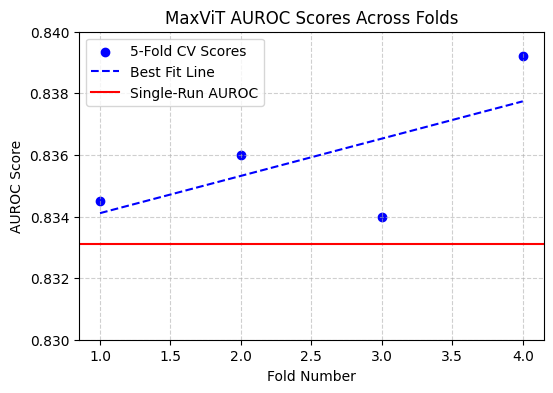

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Fold scores for MaxViT model
folds = np.array([1, 2, 3, 4])
auroc_scores = np.array([0.8345, 0.8360, 0.8340, 0.8392])
single_run_score = 0.8331  # Given single-run AUROC

# Fit a line of best fit (linear regression)
m, b = np.polyfit(folds, auroc_scores, 1)  # Linear fit

# Generate scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(folds, auroc_scores, color='blue', label="5-Fold CV Scores")
plt.plot(folds, m * folds + b, color='blue', linestyle='dashed', label="Best Fit Line")
plt.axhline(y=single_run_score, color='red', linestyle='solid', label="Single-Run AUROC")

# Labels and legend
plt.xlabel("Fold Number")
plt.ylabel("AUROC Score")
plt.ylim(0.83, 0.84)  # Focus on relevant range
plt.title("MaxViT AUROC Scores Across Folds")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()
